<a href="https://colab.research.google.com/github/Dannykik/ULPGL_work/blob/main/detection_anomalie_object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chemin du fichier (Google Drive)
file_path = "/content/drive/MyDrive/Mon_memoire_L3/UCSD_Anomaly_Dataset.tar.gz"

# Extraire l'archive dans /content
!tar -xvzf "$file_path" -C /content

Streaming output truncated to the last 5000 lines.
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/139.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/002.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/060.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/085.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/067.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/127.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/131.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/012.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/148.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/144.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/015.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/009.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/102.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/143.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/078.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/017.bmp
UCSD_

In [ ]:
!ls /content/drive/MyDrive/Mon_memoire_L3/weapon_detection

data.yaml      README.dataset.txt   train
model_results  README.roboflow.txt  weapon_detection_split


In [ ]:
import os
os.listdir('/content')

['.config',
 'yolo11n.pt',
 'runs',
 'yolov8n.pt',
 'UCSD_Anomaly_Dataset.v1p2',
 'drive',
 'sample_data']

In [ ]:
os.listdir('/content/UCSD_Anomaly_Dataset.v1p2')

['._README.txt',
 'README.txt',
 'README.txt~',
 'UCSDped1',
 'UCSDped2',
 '.DS_Store']

In [ ]:

train_path = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train'
print(os.listdir(train_path)[:5])

['Train020', 'Train002', 'Train016', 'Train019', 'Train015']


In [ ]:
test_path = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test'
print(os.listdir(test_path)[:5])

['Test025', 'Test031', 'Test019_gt', 'Test016', 'UCSDped1.m~']


#Activer le GPU (vérification)

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Charger les images (proprement)

In [ ]:
import os
import cv2
import numpy as np

IMG_SIZE = 128

def load_images_from_folder(folder):
    images = []
    for subfolder in sorted(os.listdir(folder)):
        sub_path = os.path.join(folder, subfolder)
        if os.path.isdir(sub_path):
            for file in sorted(os.listdir(sub_path)):
                if file.endswith('.tif'):
                    img_path = os.path.join(sub_path, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img = img / 255.0
                    images.append(img)
    return np.array(images)

train_folder = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train'
train_images = load_images_from_folder(train_folder)

print("Nombre d'images d'entraînement :", train_images.shape)

Nombre d'images d'entraînement : (6800, 128, 128)


#Construire l’Autoencoder CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

train_images = train_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

#Entraînement

In [ ]:
autoencoder.fit(
    train_images,
    train_images,
    epochs=10,
    batch_size=16,
    shuffle=True
)

Epoch 1/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0109
Epoch 2/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0019
Epoch 3/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0015
Epoch 4/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0012
Epoch 5/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0010
Epoch 6/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 9.1159e-04
Epoch 7/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 8.1657e-04
Epoch 8/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 7.7732e-04
Epoch 9/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 7.1720e-04
Epoch 10/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 6.7440e-04


#Détection des anomalies

In [ ]:
test_folder = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test'
test_images = load_images_from_folder(test_folder)
test_images = test_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print("Nombre d'images de test :", test_images.shape)


Nombre d'images de test : (7200, 128, 128, 1)


#Reconstruction avec l’autoencoder

In [ ]:
reconstructed = autoencoder.predict(test_images)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


#Calculer l’erreur de reconstruction

In [ ]:
mse = np.mean(np.power(test_images - reconstructed, 2), axis=(1,2,3))

#Définir un seuil

In [ ]:
threshold = np.mean(mse) + 3*np.std(mse)
print("Seuil d'anomalie :", threshold)

Seuil d'anomalie : 0.0014542614346891303


#Identifier les anomalies

In [ ]:
anomalies = mse > threshold
print("Nombre d'anomalies détectées :", np.sum(anomalies))

Nombre d'anomalies détectées : 30


#Visualiser quelques résultats

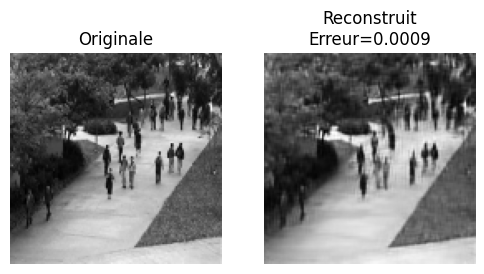

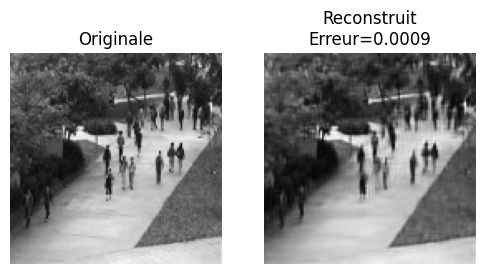

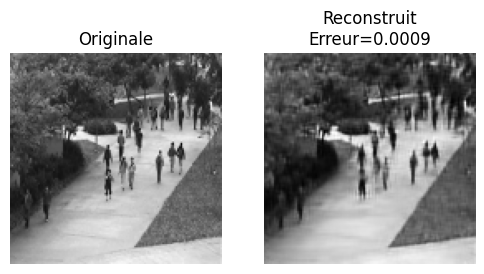

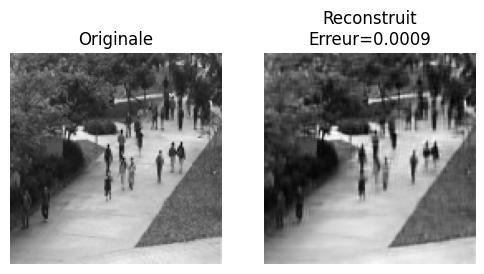

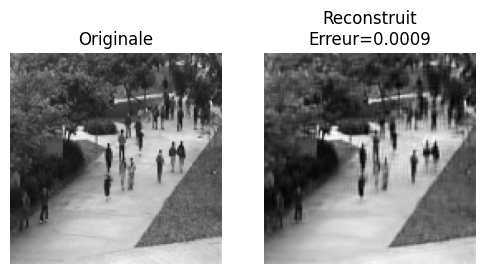

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(figsize=(6,3))
    # Image originale
    plt.subplot(1,2,1)
    plt.imshow(test_images[i].reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title("Originale")
    plt.axis('off')

    # Image reconstruite
    plt.subplot(1,2,2)
    plt.imshow(reconstructed[i].reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title(f"Reconstruit\nErreur={mse[i]:.4f}")
    plt.axis('off')

    plt.show()

In [ ]:
# Sauvegarder
autoencoder.save('/content/autoencoder_ucsd.h5')

In [ ]:
drive.mount('/content/drive')

autoencoder.save('/content/drive/MyDrive/Mon_memoire_L3/autoencoder_ucsd.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
autoencoder.save('/content/drive/MyDrive/Mon_memoire_L3/autoencoder_ucsd.h5')

#Detection model for Weapon

In [ ]:
file_path2 = "/content/drive/MyDrive/Mon_memoire_L3/Final.v1i.yolov8.zip"
!unzip "$file_path2" -d /content/drive/MyDrive/Mon_memoire_L3/weapon_detection

Archive:  /content/drive/MyDrive/Mon_memoire_L3/Final.v1i.yolov8.zip
 extracting: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/README.dataset.txt  
 extracting: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/README.roboflow.txt  
 extracting: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/data.yaml  
   creating: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train/
   creating: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train/images/
 extracting: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train/images/005f199c-194_jpeg.rf.4fb58b53ce4910faa9269f346c365ef5.jpg  
 extracting: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train/images/00917d05-290_jpeg.rf.dbff9d191a0f6a2d9f0aa7d997f3a41b.jpg  
 extracting: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train/images/011b4c4d-121_jpeg.rf.c3c0ec35b8ee6079426b8346a2fb346b.jpg  
 extracting: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train/images/013a0328-23

In [ ]:
!ls /content/drive/MyDrive/Mon_memoire_L3/weapon_detection

data.yaml  README.dataset.txt  README.roboflow.txt  train


In [ ]:
!ls /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train

images	labels


In [ ]:
!ls /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train/images | head
!ls /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train/labels | head

005f199c-194_jpeg.rf.4fb58b53ce4910faa9269f346c365ef5.jpg
00917d05-290_jpeg.rf.dbff9d191a0f6a2d9f0aa7d997f3a41b.jpg
011b4c4d-121_jpeg.rf.c3c0ec35b8ee6079426b8346a2fb346b.jpg
013a0328-231_jpeg.rf.7576069fbcdaeb810ff2554525371f76.jpg
01421639-wallpaperflare-com_wallpaper_jpg.rf.46cde7d02994f6aebcdba6c158e71e87.jpg
02338646-ep272_jpg.rf.19c6431be34445db903c59519d4ef83d.jpg
023f519a-e1391_jpg.rf.c2da2c8fe684cc7e96385d9b85cb1b10.jpg
02aff62d-104_jpeg.rf.d2e82afde3f38e6de17ca10c497ed5f5.jpg
04518e59-e1309_jpg.rf.517f83f43a5f902bebb04f77a39ab71a.jpg
04549c53-ep213_jpg.rf.8e920536660f023f7c398fc8e8097a28.jpg
005f199c-194_jpeg.rf.4fb58b53ce4910faa9269f346c365ef5.txt
00917d05-290_jpeg.rf.dbff9d191a0f6a2d9f0aa7d997f3a41b.txt
011b4c4d-121_jpeg.rf.c3c0ec35b8ee6079426b8346a2fb346b.txt
013a0328-231_jpeg.rf.7576069fbcdaeb810ff2554525371f76.txt
01421639-wallpaperflare-com_wallpaper_jpg.rf.46cde7d02994f6aebcdba6c158e71e87.txt
02338646-ep272_jpg.rf.19c6431be34445db903c59519d4ef83d.txt
023f519a-e1391_jpg.

In [ ]:
!cat /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 4
names: ['Grenade', 'Gun-Rifle-', 'Knife', 'Pistol']

roboflow:
  workspace: weapons-dataset
  project: final-hcrmc
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/weapons-dataset/final-hcrmc/dataset/1

##Split dataset into train, val and test

In [ ]:
import os
import random
import shutil

# Chemins
base_dir = "/content/drive/MyDrive/Mon_memoire_L3/weapon_detection/train"
output_dir = "/content/drive/MyDrive/Mon_memoire_L3/weapon_detection/weapon_detection_split"

splits = {
    "train": 0.7,
    "val": 0.2,
    "test": 0.1
}

# Créer les dossiers
for split in splits:
    os.makedirs(f"{output_dir}/{split}/images", exist_ok=True)
    os.makedirs(f"{output_dir}/{split}/labels", exist_ok=True)

# Lister les images
images = os.listdir(f"{base_dir}/images")
random.shuffle(images)

n_total = len(images)
train_end = int(splits["train"] * n_total)
val_end = train_end + int(splits["val"] * n_total)

split_files = {
    "train": images[:train_end],
    "val": images[train_end:val_end],
    "test": images[val_end:]
}

# Déplacer les fichiers
for split, files in split_files.items():
    for img in files:
        label = img.replace(".jpg", ".txt").replace(".png", ".txt")

        shutil.copy(f"{base_dir}/images/{img}", f"{output_dir}/{split}/images/{img}")
        shutil.copy(f"{base_dir}/labels/{label}", f"{output_dir}/{split}/labels/{label}")

print("✅ Dataset divisé avec succès")


✅ Dataset divisé avec succès


In [ ]:
for split in ["train", "val", "test"]:
    img_path = f"/content/drive/MyDrive/Mon_memoire_L3/weapon_detection/weapon_detection_split/{split}/images"
    label_path = f"/content/drive/MyDrive/Mon_memoire_L3/weapon_detection/weapon_detection_split/{split}/labels"

    print(split)
    print(" Images :", len(os.listdir(img_path)))
    print(" Labels :", len(os.listdir(label_path)))
    print("-" * 30)

train
 Images : 1191
 Labels : 1191
------------------------------
val
 Images : 340
 Labels : 340
------------------------------
test
 Images : 171
 Labels : 171
------------------------------


##Training model

In [ ]:
!cat /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/weapon_detection_split/data.yaml


train: train/images
val: val/images
test: test/images

nc: 4
names: ['Grenade', 'Gun-Rifle-', 'Knife', 'Pistol']

roboflow:
  workspace: weapons-dataset
  project: final-hcrmc
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/weapons-dataset/final-hcrmc/dataset/1


In [ ]:
import os
!pip install ultralytics

from ultralytics import YOLO

# Define the path for the new data.yaml file
data_yaml_path = "/content/drive/MyDrive/Mon_memoire_L3/weapon_detection/weapon_detection_split/data.yaml"

# Content for the new data.yaml file
data_yaml_content = f"""
train: train/images
val: val/images
test: test/images

nc: 4
names: ['Grenade', 'Gun-Rifle-', 'Knife', 'Pistol']

roboflow:
  workspace: weapons-dataset
  project: final-hcrmc
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/weapons-dataset/final-hcrmc/dataset/1
"""

# Write the content to the new data.yaml file
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

print(f"Created data.yaml at: {data_yaml_path}")

model = YOLO("yolov8n.pt")

model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16
)

Created data.yaml at: /content/drive/MyDrive/Mon_memoire_L3/weapon_detection/weapon_detection_split/data.yaml
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Mon_memoire_L3/weapon_detection/weapon_detection_split/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosai

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cc5e269c500>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
import shutil
import os

src = "/content/runs"
dst = "/content/drive/MyDrive/Mon_memoire_L3/weapon_detection/weapon_detection_split/runs"

# Supprimer l'ancien dossier s'il existe (évite les erreurs)
if os.path.exists(dst):
    shutil.rmtree(dst)

# Copier tout le dossier runs
shutil.copytree(src, dst)

print("✅ Le dossier 'runs' a été entièrement copié dans Google Drive")


✅ Le dossier 'runs' a été entièrement copié dans Google Drive
